# PDF to FAISS Query System using Google AI Studio

### Load Environment Variables

In [ ]:
import google.generativeai as genai

import os
from dotenv import load_dotenv
load_dotenv('.config')
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)

### Extract PDF Content

In [ ]:
import PyPDF2

def extract_text_from_pdf(uploaded_pdf):
    if uploaded_pdf is None:
        return ""
    text = ""
    reader = PyPDF2.PdfReader(uploaded_pdf)
    for page in reader.pages:
        text += page.extract_text() + "\n"
    return text

text = extract_text_from_pdf("***.pdf") # Input PDF File Here.
print(text)

### Chunk Texts

In [ ]:
def chunk_text(text, chunk_size=500):
    return [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]

texts = chunk_text(text)
print(texts)

### Embeddings

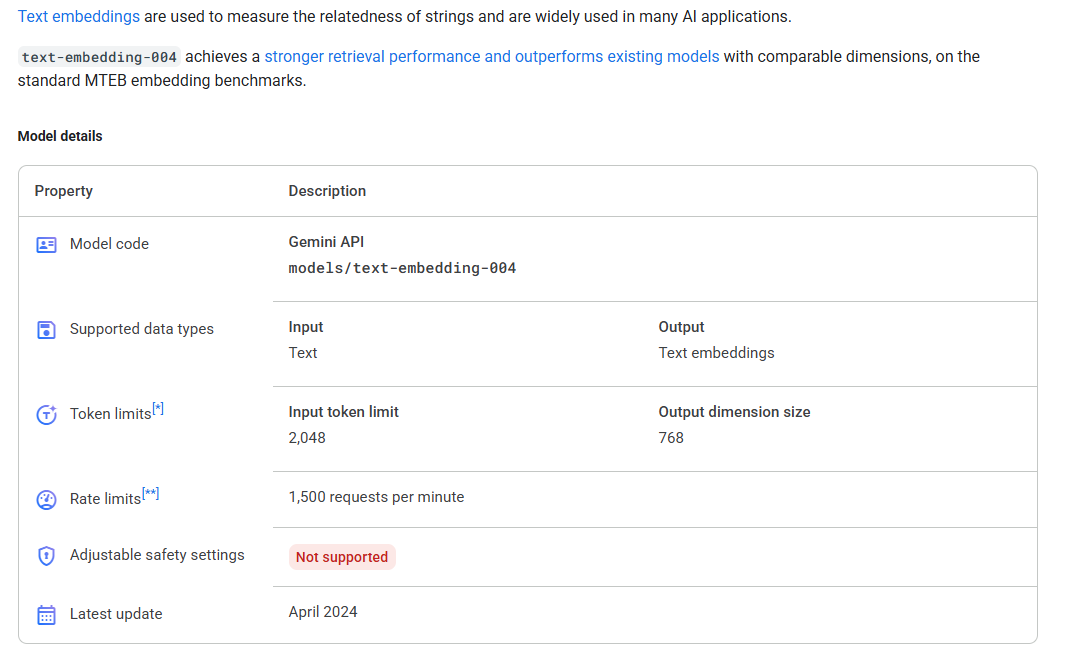

In [ ]:
embeddings = []
for text in texts:
    embedding = genai.embed_content(model="models/text-embedding-004", content=text)
    embeddings.append(embedding)

print(len(embeddings))

In [ ]:
print(type(embeddings[0]))

In [ ]:
print(embeddings[0].keys())

In [ ]:
len(embeddings[0]['embedding'])

In [ ]:
embeddings[0]

### Store texts and Embeddings into Vector Database

In [9]:
import numpy as np
import faiss
def create_faiss_index(embeddings):
    embedding_dim = len(embeddings[0]['embedding'])
    index = faiss.IndexFlatL2(embedding_dim)
    
    metadata = []  
    for text, embedding in zip(texts, embeddings):
        index.add(np.array(embedding['embedding'], dtype=np.float32).reshape(1, -1))
        metadata.append(text)
    return index, metadata

index, metadata = create_faiss_index(embeddings)

In [ ]:
index.ntotal

In [ ]:
len(metadata)

### Load Data from Vector database for Retrieval

In [12]:
import faiss
import pickle
def save_faiss_index(index, metadata, index_file="faiss.index", metadata_file="metadata.pkl"):
    faiss.write_index(index, index_file)
    with open(metadata_file, "wb") as file:
        pickle.dump(metadata, file)

save_faiss_index(index, metadata)

def load_faiss_index(index_file="faiss.index", metadata_file="metadata.pkl"):
    index = faiss.read_index(index_file)
    with open(metadata_file, "rb") as file:
        metadata = pickle.load(file)
    return index, metadata

loaded_index, loaded_metadata = load_faiss_index()

### Check Loaded Data

In [ ]:
print(f"Number of embeddings in the Loaded_index: {loaded_index.ntotal}")
print("==" * 50 )

print(f"Type of loaded_metadata: {type(loaded_metadata)}")

print(f"Number of items in loaded_metadata: {len(loaded_metadata)}")

print("==" * 50 )

print("First 3 items in loaded_metadata:")
for i, text in enumerate(loaded_metadata[:3], start=1):
    print(f"{i}: {text[:50]}...")  # First 50 characters of each chunk


### Data Retrieval from Vector database based on query context

In [ ]:
def query_vector_database(query, loaded_index, loaded_metadata):
    query_embedding = genai.embed_content(
        model="models/text-embedding-004",
        content=query
    )['embedding']

    distances, indices = loaded_index.search(np.array(query_embedding, dtype=np.float32).reshape(1, -1), k=5)
    results = [(loaded_metadata[i], distances[0][j]) for j, i in enumerate(indices[0])]
    return results


### Generate Answer based on Similarity Search

In [ ]:
def answer_question(query, loaded_index, loaded_metadata):
    relevant_texts = query_vector_database(query, loaded_index, loaded_metadata)
    context = "\n".join([text for text, _ in relevant_texts])
    model = genai.GenerativeModel("gemini-2.0-flash-exp")
    response = model.generate_content(
        f"Answer the question based on the following information:\n{context}\n\nQuestion: {query}"
    )
    return response.candidates[0].content.parts[0].text

### Evaluation

In [ ]:
query = "Question" # Ask your Question Here.
response = answer_question(query,loaded_index, loaded_metadata)
print(response)